In [2]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250


API_KEY: str = ""
SECRET_KEY: str = ""
for l in open('../../../paper.env'):
    if l.startswith("APCA_API_KEY_ID="):
        API_KEY = l.split("=")[1].strip()
    elif l.startswith("APCA_API_SECRET_KEY="):
        SECRET_KEY = l.split("=")[1].strip()

assert API_KEY
assert SECRET_KEY

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')

@lru_cache()
def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data

def run_backtest(strategy, symbol: str, start: datetime.date, end: datetime.date, params, cash: float):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

  data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
  feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
  cerebro.adddata(feed1)
 
  results = cerebro.run()

  cerebro.plot(iplot=True)

  strat = results[0]
  return strat

def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100


In [3]:
symbol = 'NRGU'
start = datetime.date(2021, 10, 1)
end = datetime.date(2022, 5, 31)
cash = 5000

In [7]:
class MyStrategy(bt.Strategy):
    def next(self):
      global end
      if self.data.datetime.date() >= end - datetime.timedelta(days=1):
        self.close()
        return
      if not self.position:
        self.order_target_percent(target=0.98)

In [8]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {}
  , cash
)

<IPython.core.display.Javascript object>

# Detail

In [9]:
annual_returns = strategy.analyzers.annualreturn.get_analysis()
analysis = strategy.analyzers.tradeanalyzer.get_analysis()
print(strategy.p.__dict__)
print(f"ROI     : {get_roi(strategy):.1%}")
print(f"Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100:.1%}")
print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")

{}
ROI     : 358.5%
Drawdown: 40.7%
Average : 1 trades @ 17927.05
Winners : 100.0% @ 17927.05
Losers  : 0.0% @ 0.00


                    Strategy
------------------  ----------
Start Period        2021-10-01
End Period          2022-05-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   358.54%
CAGR﹪              894.34%

Sharpe              2.9
Sortino             4.51
Sortino/√2          3.19
Omega               1.62

Max Drawdown        -34.68%
Longest DD Days     72

Gain/Pain Ratio     0.62
Gain/Pain (1M)      8.85

Payoff Ratio        1.26
Profit Factor       1.62
Common Sense Ratio  1.97
CPC Index           1.14
Tail Ratio          1.22
Outlier Win Ratio   2.42
Outlier Loss Ratio  3.29

MTD                 74.62%
3M                  134.56%
6M                  345.09%
YTD                 323.24%
1Y                  358.54%
3Y (ann.)           894.34%
5Y (ann.)           894.34%
10Y (ann.)          894.34%
All-time (ann.)     894.34%

Avg. Drawdown       -8.88%
Avg. Drawdown Days  8
Recovery Factor     10.34
Ulcer Index         0.14
Serenity Index      6.13


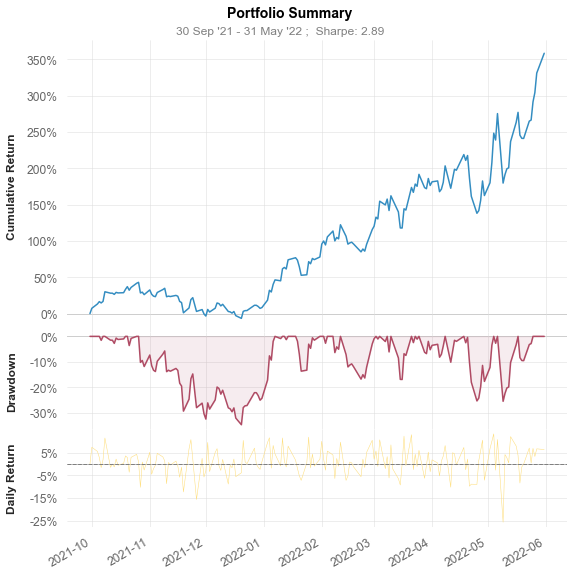

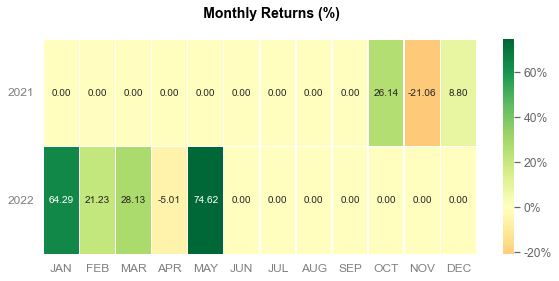

In [11]:
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.basic(returns)

In [12]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results("hodl-rungs", [types.FilledOrder(intention=None, symbol=t['symbol'], quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')], metadata.Metadata(commit_id="", last_updated=datetime.datetime.now()))